In [43]:
# Cargo las librerías
import importlib
import numpy as np
import mlflow 
import mlflow.sklearn
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import joblib
import os

# Setup de MLflow
MLFLOW_URI = os.getenv("MLFLOW_URI", "http://127.0.0.1:5000/")
mlflow.set_tracking_uri(uri=MLFLOW_URI)

# Asegurarse de que el servidor de MLflow esté corriendo
try:
    client = mlflow.tracking.MlflowClient()
    print("MLflow tracking server is running.")
except Exception as e:
    print(f"Error connecting to MLflow tracking server: {e}")

# Si no existe, creo el experimento
# A pesar de que MLFlow usa versiones, se decidio usar dos numeros para mantener 2 numeros en versiones, en caso de modificar algo en el Modelo, se cambiara el primer numero, si es solo entrenamiento, se dejara los numeros de MLflow como segundo
# Fuente: https://ed.team/blog/como-se-deciden-las-versiones-del-software
version="1"
experiment_name = f"Spike_Challenge_v{version}"

experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    print(f"Experiment '{experiment_name}' does not exist. Creating a new experiment.")
    experiment_id = mlflow.create_experiment(name=experiment_name, tags={"version": "v1"})
    experiment = mlflow.get_experiment(experiment_id)
else:
    print(f"Experiment '{experiment_name}' already exists.")


MLflow tracking server is running.
Experiment 'Spike_Challenge_v1' already exists.


In [44]:
# Generación del Dataset
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

folder_path="../dataset/train"

# Read and concatenate all CSV files
df_todotipo=pd.read_csv(os.path.join(folder_path,'data_todotipo.csv'),encoding='utf-8',sep=',')
df_todotipo=df_todotipo.dropna(how='any',axis=0).copy()
df_reggaeton=pd.read_csv(os.path.join(folder_path,'data_reggaeton.csv'),encoding='utf-8',sep=',')
df_reggaeton['reggaeton']=1
df_todotipo['reggaeton']=0
df_reggaeton['popularity']=df_reggaeton.popularity.astype('float64')
df_reggaeton['duration']=df_reggaeton.duration.astype('float64')
df=pd.concat([df_reggaeton,df_todotipo]).copy()

# Asign type for transform
df['reggaeton'] = df['reggaeton'].astype('category')
df['popularity'] = df['popularity'].astype('float64')
df['duration'] = df['duration'].astype('float64')
df.loc[:, "key_code"] = df['key'].astype('category').cat.codes
df.loc[:, "mode_code"] = df['mode'].astype('category').cat.codes

# Initialize MinMaxScaler for tempo
tempo_scaler_file = 'tempo_min_max_scaler.save'
if os.path.exists(tempo_scaler_file):
    tempo_scaler = joblib.load(tempo_scaler_file)
else:
    tempo_scaler = MinMaxScaler()

df.loc[:, 'tempo_scale'] = tempo_scaler.fit_transform(df[['tempo']].values)

# Save the MinMaxScaler if not exist
if not os.path.exists(tempo_scaler_file):
    joblib.dump(tempo_scaler, tempo_scaler_file)



# cuando aun es dataframe, separo para obtener el de validación para hacer pruebas posteriores
# es uno de los cambios que se realizarán al flujo de trabajo dejado del datascientist para que al obtener
# los resultados, sean representativos y no esten sesgados.
df_val = df.sample(int(len(df)*0.2))
df_train = df[~df.index.isin(df_val.index)]

# Drop unnecessary columns
columns_to_use = [ 'danceability', 'energy', 'speechiness', 'acousticness','valence','tempo','tempo_scale', 'reggaeton']
df_train = df_train[columns_to_use]

columns_to_use = [ 'danceability', 'energy', 'speechiness', 'acousticness','valence','tempo','tempo_scale', 'reggaeton']
df_val = df_val[columns_to_use]

# Guardo los csv por para revisar si son necesarios al haber usado random pick
df_val.to_csv("data_val.csv")
df_train.to_csv("data_train.csv")

# separo entre caracteristivas y objetivo
X = df_train.loc[:, ((df_train.columns != 'reggaeton') & (df_train.columns != 'tempo'))].values
y = df_train['reggaeton'].values.ravel()

In [45]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

Información del dataset aplicando el algoritmo Smote:
 y: Counter({1: 1767, 0: 1767})


f:\ProyectoPython\Yom\YOM_Challengue\.env\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


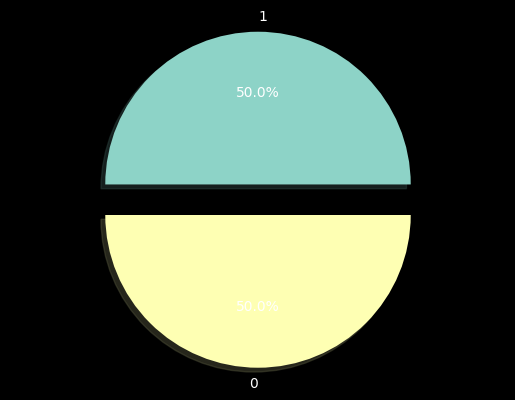

In [46]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

sm = SMOTE(random_state=0,n_jobs=-1)
X_res, y_res = sm.fit_resample(X, y)
print('Información del dataset aplicando el algoritmo Smote:'
      '\n y: {}'.format(Counter(y_res)))
plot_pie(y_res)

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
# Hago split entre train y test, validación se usara otro archivo para probar
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size= 0.2,
    random_state= 1234
    )
# Los parametros fueron cambiadas a su equivalente para las nuevas funciónes debido a la perdida del archivo requirements.txt, actualizando presort que ahora es automatica, y max_features que ahora es sqrt
classifier_GB=GradientBoostingClassifier(
    random_state=0,subsample=0.8,n_estimators=300,warm_start=True,
    max_features='sqrt', min_samples_split=106,min_samples_leaf=177)

In [48]:
# Devuelvo a DataFrame para prevenir el Warning de usar feature names y mejorar la legibilidad y mantenimiento del código
df_train = pd.DataFrame(data=X_train, columns=[ 'danceability', 'energy', 'speechiness', 'acousticness','valence','tempo'])
# Entrenar el modelo con los datos de entrenamiento
classifier_GB.fit(df_train, y_train)

GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=177,
                           min_samples_split=106, n_estimators=300,
                           random_state=0, subsample=0.8, warm_start=True)

In [49]:
from mlflow.types.schema import Schema, ColSpec
from mlflow.models.signature import ModelSignature
from datetime import datetime
# Ahora hago el loging de los parámetros, se le asignar nombre a run para estar seguros de la prueba para identificarla del resto, asegurar un nombre distinto con la UI
with mlflow.start_run(experiment_id = experiment.experiment_id, run_name=f"Run_{datetime.now()}"):

    # Logueo los mejores resultados
    mlflow.log_params({
        "n_estimators": classifier_GB.n_estimators,
        "max_depth": classifier_GB.max_depth,
        "learning_rate": classifier_GB.learning_rate,
        "train_length": len(X_train),
        "test_length": len(X_test),
        "MinMaxScaler_min": tempo_scaler.data_min_[0],
        "MinMaxScaler_max": tempo_scaler.data_max_[0]
    }) 
    # Transformo los datos para prevenir warnings de feature names
    df_test = pd.DataFrame(data=X_test, columns=[ 'danceability', 'energy', 'speechiness', 'acousticness','valence','tempo'])

    # Obtengo las predicciones
    y_pred = classifier_GB.predict(df_test)

    # Calculo el acuraccy y el AUC
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}')

    # Log de parámetros
    metrics ={
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall 
        }

    mlflow.log_metrics(metrics)

    # Definir los esquema manualmente
    input_schema = Schema([
        ColSpec("float", "danceability"),
        ColSpec("float", "energy"),
        ColSpec("float", "speechiness"),
        ColSpec("float", "acousticness"),
        ColSpec("float", "valence"),
        ColSpec("float", "tempo")
    ])

    output_schema = Schema([ColSpec("integer")])
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)
    input_example = [X_train[0]]
    # Guardar modelo en MLflow
    mlflow.sklearn.log_model(classifier_GB, f"Reggaeton_Classifier_V{version}",signature=signature, input_example=input_example)


Accuracy: 0.988950276243094
Precision: 0.9890730509515041
Recall: 0.988950276243094


In [50]:
# Define el ID de tu experimento
experiment_id = "1"  # Reemplaza con el ID de tu experimento

# Obtén una lista de todas las ejecuciones en el experimento
runs = mlflow.search_runs(experiment_ids=experiment.experiment_id)

# Encuentra la ejecución con la mejor métrica
best_run = runs.loc[runs['metrics.accuracy'].idxmax()]

# Obtiene el URI del modelo de la mejor ejecución
model_uri = best_run.artifact_uri +  f"/Reggaeton_Classifier_V{version}"
model_uri

'mlflow-artifacts:/3/622b46db9f7540aa9596d935594b0c35/artifacts/Reggaeton_Classifier_V1'

In [51]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score

# Cargar el modelo guardado desde MLflow
loaded_model = mlflow.sklearn.load_model(model_uri=model_uri)

# Devuelvo a DataFrame para prevenir el Warning de usar feature names y mejorar la legibilidad y mantenimiento del código
df_test = pd.DataFrame(data=X_test, columns=[ 'danceability', 'energy', 'speechiness', 'acousticness','valence','tempo'])

# Realizar predicciones en el conjunto de prueba
y_pred = loaded_model.predict(df_test)

# Calculo el acuraccy y el AUC
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Log de parámetros
metrics ={
    'accuracy': accuracy,
    'precision': precision, 
    'recall': recall 
    }

metrics


f:\ProyectoPython\Yom\YOM_Challengue\.env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


{'accuracy': 0.9917127071823204,
 'precision': 0.9917819603256437,
 'recall': 0.9917127071823204}

### Para publicar el modelo de MLflow como un endpoint
De cara a poner un modelo de MLflow en producción como endpoint podemos hacer alguna de estas opciones:

1. Hacer el deploy en el propio servidor de MLflow.
2. Hacer el deploy en una herramienta Cloud externa, como AWS SageMaker, Azure ML o Apache Spark UDF.
3. Descargar el modelo como Docker y ponerlo en producción en cualquier otra herramienta.

En mi caso usaré la tercera opción, ya que permite controlar el trafico y opciones avanzadas como auto escalado.

In [57]:
# primero, pruebas sin el transformador, para asegurar resultados
import requests
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score

# URL del servidor MLflow donde está alojado tu modelo
apikey = "kXwagyJkMH0Q3fT3MorqmRupqpjq1FCsVijy2P3nwrQQpExcWl"
model_uri = f"http://127.0.0.1:8000/predict/?transform=false&apikey={apikey}"

# guardo resultados
y_pred=[]

# Datos de prueba para hacer predicciones
for x, y in zip(X_test, y_test):
  data = {
    "danceability": x[0],
    "energy": x[1],
    "speechiness": x[2],
    "acousticness": x[3],
    "valence": x[4],
    "tempo": x[5]
  }

  # Hacer una solicitud POST al servidor MLflow para obtener predicciones
  headers = {'Content-type': 'application/json'}
  response = requests.post(f"{model_uri}", headers=headers,data=json.dumps(data))

  # Extraer las predicciones del JSON de respuesta
  json_response = response.json()
  y_pred.append(json_response['id'])
# Calcular métricas (opcional)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Log de parámetros (opcional)
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall
}

print("Metrics:")
metrics

Metrics:


{'accuracy': 0.988950276243094,
 'precision': 0.9890730509515041,
 'recall': 0.988950276243094}

Ahora que probamos que el modelo en la API esta dando resultados similares sin el transformador, comprobaremos con el transformador para descargar futuros problemas

In [58]:
import requests
from sklearn.metrics import accuracy_score, precision_score, recall_score
import json

# URL del servidor MLflow donde está alojado tu modelo
apikey = "kXwagyJkMH0Q3fT3MorqmRupqpjq1FCsVijy2P3nwrQQpExcWl"
model_uri = f"http://127.0.0.1:8000/predict/?apikey={apikey}"

# cargamos el csv de val que guardamos previamente, como ya esta mayormente procesado, no necesita procesar
df=pd.read_csv('data_val.csv',encoding='utf-8',sep=',')

# Datos de prueba para hacer predicciones
y_pred=[] # guardo resultados
y_val=[] # guardo respuesta correcta
for index, row in df.iterrows():
  data = {
    "danceability": row['danceability'],
    "energy": row['energy'],
    "speechiness": row['speechiness'],
    "acousticness": row['acousticness'],
    "valence": row['valence'],
    "tempo": row['tempo']
  }

  # Hacer una solicitud POST al servidor MLflow para obtener predicciones
  headers = {'Content-type': 'application/json'}
  response = requests.post(f"{model_uri}", headers=headers,data=json.dumps(data))

  # Extraer las predicciones del JSON de respuesta
  json_response = response.json()
  y_pred.append(json_response['id'])
  y_val.append(row['reggaeton'])
# Calcular métricas (opcional)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')

# Log de parámetros (opcional)
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall
}

print("Metrics:")
metrics

Metrics:


{'accuracy': 0.9716157205240175,
 'precision': 0.9642433258153782,
 'recall': 0.9716157205240175}

Con estas pruebas, aseguramos la correcta puesta en producción de la API, por un lado el modelo entrenado, y por otro que el MinMaxScaler no tenga problemas para entregar los datos al modelo.

## Extra
Se analizo el uso de IsolationForest, sin embargo, no se termino de implementar por ahora ya que no se quiso alterar en gran medida el flujo de entrenamiento del datascientist, por lo que solo dejo el codigo como sugerencia para el futuro

In [61]:
from sklearn.ensemble import IsolationForest
# Crear y entrenar el modelo de Isolation Forest
detector_anomalias = IsolationForest(contamination=0.1)

detector_anomalias.fit(X_train)

# Evaluar el modelo en datos de prueba filtrados
X_test_filtrado = X_test[detector_anomalias.predict(X_test) == 1]
y_test_filtrado = y_test[detector_anomalias.predict(X_test) == 1]

# Devuelvo a DataFrame para prevenir el Warning de usar feature names y mejorar la legibilidad y mantenimiento del código
df_X_test_filtrado = pd.DataFrame(data=X_test_filtrado, columns=[ 'danceability', 'energy', 'speechiness', 'acousticness','valence','tempo'])

y_pred = classifier_GB.predict(df_X_test_filtrado)
accuracy = accuracy_score(y_test_filtrado, y_pred)
precision = precision_score(y_test_filtrado, y_pred, average='weighted')
recall = recall_score(y_test_filtrado, y_pred, average='weighted')

# Log de parámetros (opcional)
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall
}

print("Metrics:")
metrics

Metrics:


{'accuracy': 0.9876543209876543,
 'precision': 0.9878076834598574,
 'recall': 0.9876543209876543}